## Deep Learning Final Project

- pretrained CLIP에 fine tuning을 진행하지 않고 바로 zero shot transfer하였을 떄의 성능 확인!

- fine tuning한 것과의 성능을 비교하기 위해 똑같이 validation set만을 사용해 성능을 평가해야 함

### student id : 2020250012
### student name: 나지혜

## Data load

In [1]:
!pip install tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install kaggle --upgrade

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zlhwttv2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zlhwttv2
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "jeehyenaa"
os.environ['KAGGLE_KEY'] = "321d96dcbf40ba979d91fc5d290d687d" # Enter your Kaggle key here


# Dog Emotion Dataset
os.system('kaggle datasets download -d danielshanbalico/dog-emotion')

0

In [3]:
import zipfile
import os

# 압축 파일 경로
zip_path = 'dog-emotion.zip' # 다운로드한 zip 파일의 경로
extract_path = 'dog_emotion' # 압축을 풀 폴더 경로

# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"압축 해제 완료: {extract_path}")

압축 해제 완료: dog_emotion


In [4]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
import os
import pandas as pd
import numpy as np
import cv2
from random import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Preprocessing

ref: https://www.kaggle.com/code/crn4tww/dog-emotions-classifier

In [5]:
# 데이터셋 경로 설정
data_path = 'dog_emotion/Dog Emotion/' # 여기서는 압축 해제된 폴더 경로로 설정

class_names = sorted(os.listdir(data_path))
# remove labels.csv because it's not a class
class_names.remove('labels.csv')
num_classes = len(class_names)

img_size = (224, 224, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')

4 classes: ['angry', 'happy', 'relaxed', 'sad']
image size: (224, 224, 3)


In [6]:
images = []
labels = []
labels_df = pd.read_csv('dog_emotion/Dog Emotion/labels.csv')

print('\n\nlabels dataframe: \n', labels_df.head())

for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(data_path + image[2] + '/' + image[1], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))

    # 원-핫 인코딩 대신 클래스 인덱스를 직접 사용
    label = class_names.index(image[2])
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')




labels dataframe: 
    Unnamed: 0                               filename    label
0           0  yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg      sad
1           1  c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg      sad
2           2  RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg    angry
3           3  gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg    angry
4           4  U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg  relaxed

labels shape: (4000,)
images shape: (4000, 224, 224, 3)


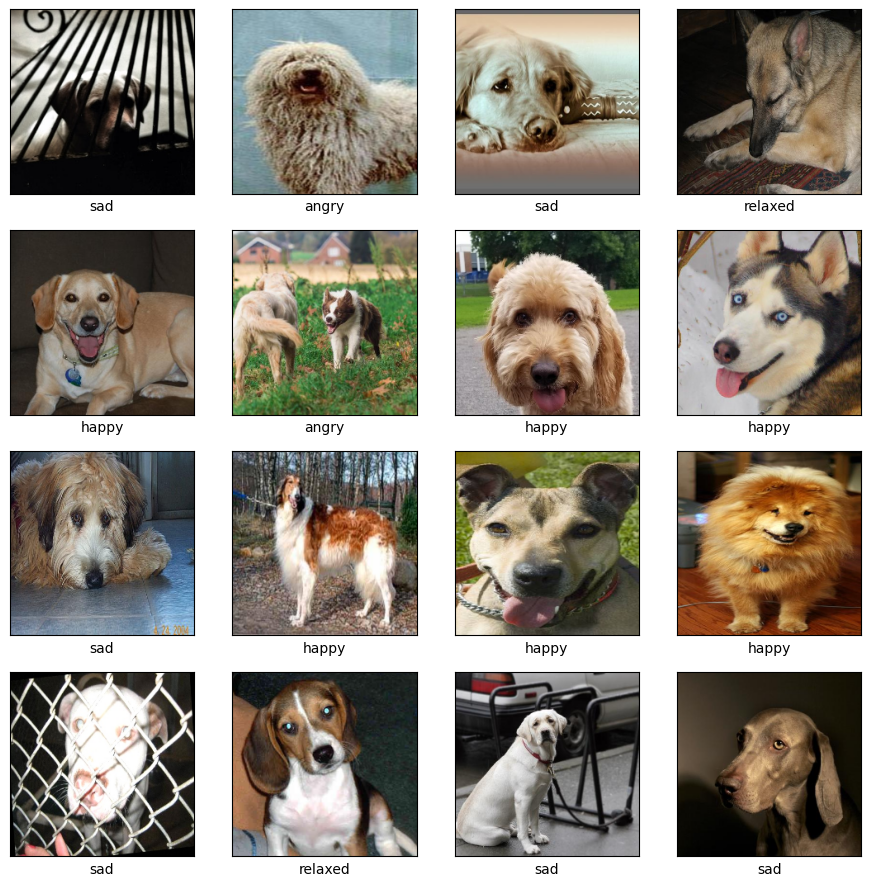

In [7]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(11, 11))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])

        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[labels[i]])

plt.show()

In [8]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (3200, 224, 224, 3)
train labels shape: (3200,)

validation images shape: (800, 224, 224, 3)
validation labels shape: (800,)



In [9]:
import numpy as np

# y_train 및 y_val에서 고유한 요소 및 그 빈도수 계산
unique, counts = np.unique(y_train, return_counts=True)
train_distribution = dict(zip(unique, counts))

unique, counts = np.unique(y_val, return_counts=True)
val_distribution = dict(zip(unique, counts))

print("Training set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)

Training set distribution: {0: 811, 1: 799, 2: 794, 3: 796}
Validation set distribution: {0: 189, 1: 201, 2: 206, 3: 204}


## Fine tuning

In [10]:
# CLIP 모델 로드
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 143MiB/s]


In [11]:
# emotion_folders = ['angry', 'happy', 'relaxed', 'sad']

In [12]:
class DogEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, preprocess):
        self.images = images
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 이미지 전처리
        image = self.preprocess(Image.fromarray(self.images[idx]).convert("RGB"))
        # 클래스 인덱스 반환
        label = self.labels[idx]

        return image, label

# 데이터셋 및 데이터로더 초기화
train_dataset = DogEmotionDataset(X_train, y_train, preprocess)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 첫 번째 배치의 형식 확인
for images, texts in train_dataloader:
    print("이미지 형식:", images.shape)
    print("텍스트 형식:", texts.shape)
    break  # 첫 번째 배치만 확인하고 루프 종료

# 이미지 형식: torch.Size([128, 3, 224, 224])
# 텍스트 형식: torch.Size([128, 77]) 77은 텍스트 시퀀스의 길이.
# (CLIP에서 사용하는 크기로, PNEUMONIA 외의 부분들은 알아서 padding이 됨)

이미지 형식: torch.Size([128, 3, 224, 224])
텍스트 형식: torch.Size([128])


In [13]:
# 모델의 파라미터를 FP32 형식으로 변환하는 함수
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

# 옵티마이저 준비
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.05) # 원래는 weight dacay 0.2였음.

# 손실 함수 지정
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# 모델 학습
num_epochs = 30
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for images, labels in pbar:
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)  # DataLoader로부터 반환된 실제 클래스 인덱스

        # 실제 클래스 이름을 사용하여 텍스트 토큰화
        texts = clip.tokenize([class_names[label] for label in labels.cpu().numpy()]).to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # 실제 클래스 인덱스를 나타내는 ground_truth 생성
        ground_truth = labels

        # 손실 계산
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2

        # Backward pass
        total_loss.backward()
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)  # CLIP 모델의 가중치를 업데이트

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

Epoch 29/30, Loss: 4.8516: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


In [14]:
# Validation 데이터셋 준비
val_dataset = DogEmotionDataset(X_val, y_val, preprocess)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

def evaluate_model(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 설정
    total = 0
    correct = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # 텍스트 토큰화 및 장치 이동
            texts = clip.tokenize([class_names[label] for label in labels.cpu().numpy()]).to(device)

            # Forward pass
            logits_per_image, _ = model(images, texts)
            predictions = logits_per_image.argmax(dim=1)

            # 정확도 계산
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


# Validation 데이터셋을 사용하여 모델 평가
val_accuracy = evaluate_model(model, val_dataloader, device)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.1375


In [15]:
# prompt engineering 관련해서도 다양한 시도 해보면 좋을듯

## 시각화

In [16]:
# epoch에 따른 train loss와 test loss plot

##(방법1) Zero-shot Transfer 시의 성능 확인 (without fine tuning)


In [23]:
import torch
import clip
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# CLIP 모델 및 사전 처리 루틴 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Prompt 예시 목록
prompts = [
    "{}",
    "A photo of a {}",
    "A photo of a {} dog",
    "This dog looks {}",
    "Imagine a {} dog"
]

# 각 prompt에 대한 정확도를 계산하는 함수
def calculate_accuracy_for_prompt(prompt):
    text_descriptions = [prompt.format(emotion) for emotion in class_names]
    text_tokens = clip.tokenize(text_descriptions).to(device)

    predictions = []
    for image in tqdm(X_val):
        image = Image.fromarray(image)
        image = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_tokens)

            logits = image_features @ text_features.T
            pred = logits.argmax(dim=-1).cpu().numpy()[0]

        predictions.append(pred)

    accuracy = accuracy_score(y_val, predictions)
    return accuracy

# 각 prompt에 대한 정확도 계산 및 출력
for prompt in prompts:
    accuracy = calculate_accuracy_for_prompt(prompt)
    print(f"Accuracy for prompt '{prompt}': {accuracy:.4f}")

100%|██████████| 800/800 [00:18<00:00, 42.77it/s]


Accuracy for prompt '{}': 0.5387


100%|██████████| 800/800 [00:18<00:00, 43.78it/s]


Accuracy for prompt 'A photo of a {}': 0.6000


100%|██████████| 800/800 [00:18<00:00, 44.36it/s]


Accuracy for prompt 'A photo of a {} dog': 0.6325


100%|██████████| 800/800 [00:19<00:00, 41.88it/s]


Accuracy for prompt 'This dog looks {}': 0.5563


100%|██████████| 800/800 [00:24<00:00, 32.68it/s]

Accuracy for prompt 'Imagine a {} dog': 0.5925


In [19]:
# # 모든 image set을 사용한 경우!
# # fine tuning 한 것과 비교하려면 validation set에 대한 성능만을 구해야 함.
# import torch
# import clip
# from PIL import Image
# from tqdm import tqdm
# from sklearn.metrics import accuracy_score

# # CLIP 모델 및 사전 처리 루틴 로드
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

# # 각 클래스(감정)에 대한 텍스트 설명 생성
# text_descriptions = [f"A photo of a {emotion} dog" for emotion in class_names]
# text_tokens = clip.tokenize(text_descriptions).to(device)

# # 모델을 사용하여 이미지 분류
# predictions = []

# for image in tqdm(images):
#     # 이미지가 Tensor 객체인 경우 이를 numpy 배열로 변환하고, 데이터 타입을 uint8로 변경
#     if isinstance(image, torch.Tensor):
#         image = image.permute(1, 2, 0).cpu().numpy()  # Tensor를 numpy 배열로 변환 (CHW -> HWC)
#         image = (image * 255).astype(np.uint8)  # float32에서 uint8로 데이터 타입 변경

#     # 이미지가 numpy 배열인 경우 데이터 타입을 uint8로 변경
#     elif isinstance(image, np.ndarray) and image.dtype != np.uint8:
#         image = (image * 255).astype(np.uint8)

#     # 이미지를 PIL 이미지로 변환
#     image = Image.fromarray(image)

#     # 이미지 전처리 및 장치에 로드
#     image = preprocess(image).unsqueeze(0).to(device)

#     # Forward pass
#     with torch.no_grad():
#         image_features = model.encode_image(image)
#         text_features = model.encode_text(text_tokens)

#         # 유사도 계산 및 최대 유사도를 가진 클래스 예측
#         logits = image_features @ text_features.T
#         pred = logits.argmax(dim=-1).cpu().numpy()[0]

#     predictions.append(pred)

# # 정확도 계산 전에 labels를 CPU로 이동시키고 numpy 배열로 변환
# labels_cpu = labels.cpu().numpy()

# # 정확도 계산
# accuracy = accuracy_score(labels_cpu, predictions)
# print(f"Zero-shot Learning accuracy: {accuracy:.4f}")


## (방법2) Hugging face 제공 버전으로 zero-shot (without fine tuning)

코드가 좀 다르긴 하지만, 결국 같은 일 하는 거다

fine tuning했을 떄의 성능과 비교하기 위해 X_val와 y_val에 대한 fine tuning 안했을 떄의 CLIP의 Zero shot transfer 성능 확인


아래의 코드로 시행하면 매 시행마다 accuracy가 달라져서 사용하지 않겠다!
(방법1) 로 했을 떄는 동일한 prompt로 재시행하면 같은 accuracy가 나옴

In [20]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

# Hugging Face의 CLIP 모델 및 프로세서 로드
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 모델을 평가 모드로 설정
model.eval()

# GPU 사용 설정 (사용 가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 각 클래스(감정)에 대한 텍스트 설명 생성
# prompt 예시
# A photo of a {emotion}   CLIP 논문에 제시된 prompt
# A photo of a {emotion} dog
# This dog looks {emotion}
# imagine a {emotion} dog



text_descriptions = [f"A photo of {emotion} dog" for emotion in class_names]
inputs = processor(text=text_descriptions, return_tensors="pt", padding=True).to(device)

# 검증 데이터셋에 대한 예측
predictions = []

for image in tqdm(X_val):         # X_val 이용
    # 이미지를 PIL 이미지로 변환하고 프로세싱
    image = Image.fromarray(image)
    inputs_image = processor(images=image, return_tensors="pt")
    inputs_image = {k: v.to(device) for k, v in inputs_image.items()}

    # 모델을 이용한 예측
    with torch.no_grad():
        outputs = model(**inputs_image, **inputs)
        logits_per_image = outputs.logits_per_image  # 이미지에 대한 로짓
        pred = logits_per_image.argmax(-1).cpu().numpy()[0]

    predictions.append(pred)

# 정확도 계산
accuracy = accuracy_score(y_val, predictions)         # y_val과 prediction 비교
print(f"Zero-shot Learning accuracy on validation set: {accuracy:.4f}")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Zero-shot Learning accuracy on validation set: 0.6138


In [21]:
# 지금 결과로 봐서는 X_val, y_val에 대한 fine tuning안한 성능이 0.6325로 더 높아보임...
# prompt를 잘줘서 그런가...